<a href="https://colab.research.google.com/github/spatank/CIS-700/blob/master/Project/networks_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive Initialization and Imports

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/Drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/Drive


In [0]:
import os
os.chdir('Drive/My Drive/CIS-700')

In [3]:
!ls Data/

hpff_dp_narrative_chains_counts_clusters.txt
hpff_dp_narrative_chains_counts_NNPs.txt
hpff_sr_narrative_chains_counts_clusters_large.txt
hpff_sr_narrative_chains_counts_clusters.txt
hpff_sr_narrative_chains_counts_NNPs_large.txt
hpff_sr_narrative_chains_counts_NNPs_new.txt
hpff_sr_narrative_chains_counts_NNPs.txt


In [4]:
import util

import pandas as pd

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
from nltk.util import ngrams

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from textblob import TextBlob # for sentiment analysis

import networkx as nx

import scipy.io as sio

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Extract Event Chains by Character

In [114]:
# data_path = 'Data/hpff_sr_narrative_chains_counts_clusters.txt'
data_path = 'Data/hpff_sr_narrative_chains_counts_NNPs_new.txt'
data = util.load_json(data_path)
all_verbs = []
verbs_dict = {}
for cluster, narrative_chains in data.items(): 
  tag = nltk.tag.pos_tag([cluster])[0][1] # get cluster tag
  # filter for noun phrases
  if tag in ['NN', 'NNP', 'NNS']: 
    verb_chains = []
    # convert list of actions by the character into a Pandas DataFrame
    df = pd.DataFrame.from_records(narrative_chains)  
    # split the ['story','chapter'] column into 'story' and 'chapter' columns
    df[['story','chapter']] = pd.DataFrame(df[0].values.tolist(), index = df.index)
    # remove the now redundant ['story','chapter'] column
    df.drop(df.columns[0], axis = 1, inplace = True)
    # move 'story' and 'chapter' columns to the front for ease of viewing
    cols = list(df)
    # grab the 'chapter' column and place at the front of the DataFrame
    cols.insert(0, cols.pop(cols.index('chapter')))
    df = df.loc[:, cols]
    # now grab the 'story' column and place at the front of the DataFrame
    cols.insert(0, cols.pop(cols.index('story')))
    df = df.loc[:, cols]
    # group the DataFrame for this character by the story number
    story_groups = df.groupby(by = 'story')
    # now iterate over the grouped stories to group by chapter number
    for story_idx in story_groups.groups:
      # get the story group as a DataFrame to allow grouping by chapter
      story = story_groups.get_group(story_idx)
      # print(story)
      chapter_groups = story.groupby(by = 'chapter')
      for chapter_idx in chapter_groups.groups:
        # get the chapter group as a DataFrame 
        chapter = chapter_groups.get_group(chapter_idx)
        # print(chapter)
        chapter_action_chain = []
        for idx, row in chapter.iterrows():
          # column titled '2' corresponds to the verb, check that it exists
          # if it is present in the DataFrame, check that it is not None
          # 0-th entry corresponds to the semantic role
          if 2 in row.index:
            if row[2] is not None:
              if row[2][0] == 'B-V': 
                verb = lemmatizer.lemmatize(row[2][1], 'v') 
                chapter_action_chain.append(verb)
                all_verbs.append(verb)
        # a single action is uninteresting from a narrative chain perspective
        if len(chapter_action_chain) > 1:
          verb_chains.append(chapter_action_chain)
    verbs_dict[cluster] = verb_chains

File Path:  Data/hpff_sr_narrative_chains_counts_NNPs_new.txt


In [118]:
c = Counter(all_verbs)
print(c)

Counter({'be': 16535, 'know': 5301, 'go': 3885, 'get': 3461, 'say': 3458, 'have': 3401, 'think': 3030, 'leave': 2836, 'look': 2273, 'walk': 2215, 'make': 2172, 'love': 1997, 'take': 1869, 'turn': 1853, 'smile': 1722, 'want': 1693, "'m": 1471, 'do': 1455, 'hope': 1453, 'fell': 1431, 'see': 1395, 'come': 1375, 'find': 1289, 'tell': 1157, 'like': 1134, 'give': 1131, 'felt': 1111, 'hear': 1106, 'try': 1050, 'run': 925, 'kiss': 922, 'let': 902, 'need': 896, 'start': 891, 'read': 891, "'s": 873, 'write': 868, 'sit': 828, 'stand': 796, 'watch': 788, 'close': 768, 'begin': 767, 'laugh': 760, 'wait': 749, 'appreciate': 740, 'head': 731, 'pull': 730, 'help': 720, 'follow': 715, 'feel': 714, 'sleep': 710, 'nod': 693, 'put': 673, 'ask': 664, 'enjoy': 651, 'wonder': 624, 'fall': 607, 'keep': 603, 'saw': 597, 'hop': 561, 'change': 541, 'decide': 529, 'hold': 520, 'promise': 513, 'continue': 503, 'drift': 503, 'disappear': 500, 'grab': 491, 'stop': 490, 'reply': 481, 'talk': 477, 'star': 474, 'open':

In [119]:
len(all_verbs)

161946

In [120]:
len(np.unique(all_verbs))

4153

In [121]:
# most common verbs
filtered_ten = [word for word, cnt in c.most_common(10)]
filtered_ten

# least common verbs
# filtered_ten = c.most_common()[:-10:-1]
# filtered_ten

['be', 'know', 'go', 'get', 'say', 'have', 'think', 'leave', 'look', 'walk']

In [0]:
new_list_verbs = [verb for verb in all_verbs if verb in filtered_ten]

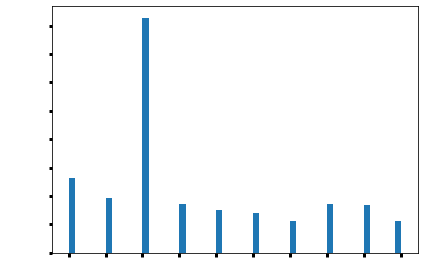

In [123]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(new_list_verbs, bins = 'auto') 
ax.tick_params(labelcolor = 'w', labelsize = 'large', width = 3)
fig.tight_layout()
# ax.set_title("Histogram of Verb Frequency")
plt.savefig('most_common_hist.png')
plt.show()

In [0]:
g_global = nx.DiGraph()
g_global.add_nodes_from(np.unique(all_verbs))

for character, verb_chains in verbs_dict.items():
  for verb_chain in verb_chains:
    edges_between = list(ngrams(verb_chain, 2))
    for edge in edges_between:
      from_node = edge[0]
      to_node = edge[1]
      if from_node == to_node:
        continue # skip a self-edge
      if g_global.has_edge(from_node, to_node):
        g_global[from_node][to_node]['weight'] += 1
      else:
        g_global.add_edge(from_node, to_node, weight = 1)

nx.write_graphml(g_global, 'global_verb_network_ff.graphml')
A = nx.adjacency_matrix(g_global, nodelist = np.unique(all_verbs), weight = 'weight')
sio.savemat('global_A_large.mat', dict(A = A.todense()))

In [0]:
all_graphs = {}

for character, verb_chains in verbs_dict.items():
  # get the verbs for this character
  char_verbs = np.unique([verb for verb_chain in verb_chains for verb in verb_chain])
  g = nx.DiGraph()
  g.add_nodes_from(char_verbs)
  # each value in the verbs_dict is a list of lists
  # each sub-list is a chain of verbs 
  for verb_chain in verb_chains:
    edges_between = list(ngrams(verb_chain, 2))
    for edge in edges_between:
      from_node = edge[0]
      to_node = edge[1]
      if from_node == to_node:
        continue # skip a self-edge
      if g.has_edge(from_node, to_node):
        g[from_node][to_node]['weight'] += 1
      else:
        g.add_edge(from_node, to_node, weight = 1)
  all_graphs[character] = g

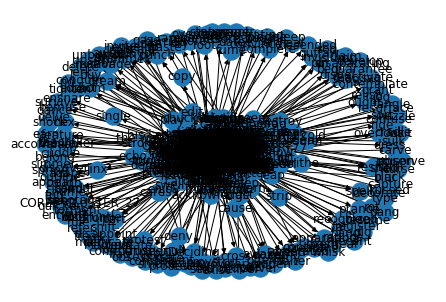

In [133]:
draco_graph = all_graphs['Draco']
nx.write_graphml(draco_graph, 'draco_verb_network_ff.graphml')
nx.draw(draco_graph, with_labels = True)

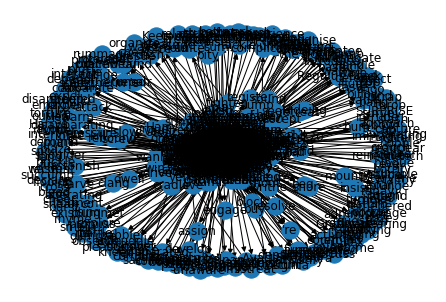

In [134]:
harry_graph = all_graphs['Harry']
nx.write_graphml(harry_graph, 'harry_verb_network_ff.graphml')
nx.draw(harry_graph, with_labels = True)

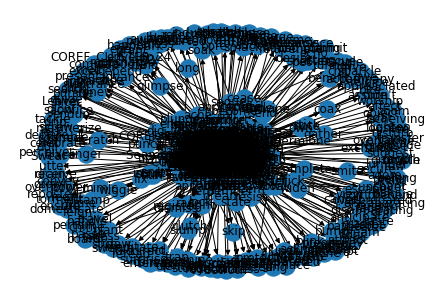

In [135]:
hermione_graph = all_graphs['Hermione']
nx.write_graphml(hermione_graph, 'hermione_verb_network_ff.graphml')
nx.draw(hermione_graph, with_labels = True)

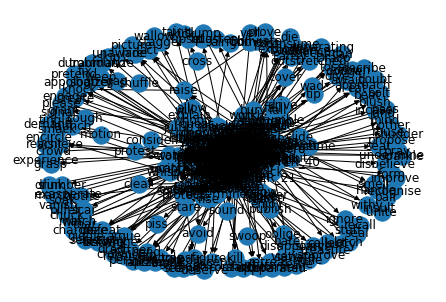

In [136]:
ron_graph = all_graphs['Ron']
nx.write_graphml(ron_graph, 'ron_verb_network_ff.graphml')
nx.draw(ron_graph, with_labels = True)

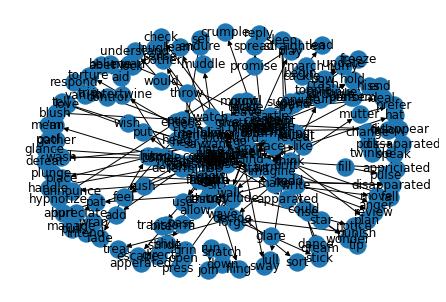

In [137]:
voldemort_graph = all_graphs['Voldemort']
nx.write_graphml(voldemort_graph, 'voldemort_verb_network_ff.graphml')
nx.draw(voldemort_graph, with_labels = True)